In [5]:
import pandas as pd
import tensorflow 
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy
import re
import sklearn
from sklearn.model_selection import train_test_split
import tqdm
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from gensim.models import Word2Vec
from tensorflow.keras import Sequential
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.pipeline import make_pipeline
from tensorflow.keras import datasets,models,layers
from tensorflow.keras.layers import Conv1D, Concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D, Dense, Embedding, Input,BatchNormalization
from tensorflow.keras.models import Model

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ANGEL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
pip install spacy

  Obtaining dependency information for spacy from https://files.pythonhosted.org/packages/92/fb/d1f0605e1e8627226c6c96053fe1632e9a04a3fbcd8b5d715528cb95eb97/spacy-3.7.4-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for spacy-legacy<3.1.0,>=3.0.11 from https://files.pythonhosted.org/packages/c3/55/12e842c70ff8828e34e543a2c7176dac4da006ca6901c9e8b43efab8bc6b/spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata
  Obtaining dependency information for spacy-loggers<2.0.0,>=1.0.0 from https://files.pythonhosted.org/packages/33/78/d1a1a026ef3af911159398c939b1509d5c36fe524c7b644f34a5146c4e16/spacy_loggers-1.0.5-py3-none-any.whl.metadata
  Obtaining dependency information for murmurhash<1.1.0,>=0.28.0 from https://files.pythonhosted.org/packages/71/46/af01a20ec368bd9cb49a1d2df15e3eca113bbf6952cc1f2a47f1c6801a7f/murmurhash-1.0.10-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for cymem<2.1.0,>=2.0.2 from https://files.pythonhosted.org/packages/c1/c3/dd

In [7]:
data = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding = 'ISO-8859-1',header=None)

In [8]:
data = data[[5, 0]]
data.columns=['tweet', 'sentiment']

In [9]:
data['sentiment'] = data['sentiment'].replace(4,1)

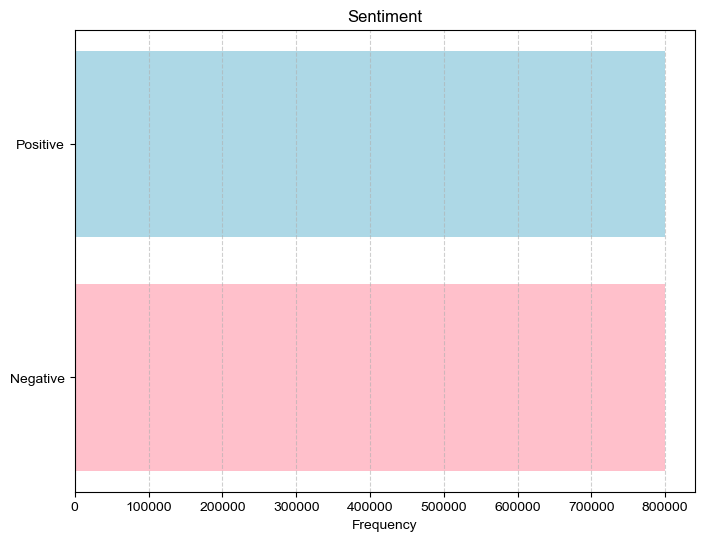

In [11]:
plt.rcParams['font.family'] = 'Arial'
sentiment_counts = data['sentiment'].value_counts()
sentiment_labels = {'Negative': 0, 'Positive': 1}
plt.figure(figsize=(8, 6))
plt.barh(list(sentiment_labels.keys()), list(sentiment_counts.values), color=['pink','lightblue', 'blue'])
plt.xlabel("Frequency")
plt.yticks(list(sentiment_labels.values()), list(sentiment_labels.keys()))
plt.title("Sentiment")
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

In [25]:
##pre-processing:

In [12]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    # Removing URLS
    text = re.sub(r"https?://\S+|www\.\S+"," ",text)
    
    # Removing html tags
    text = re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});"," ",text)
    
    # Removing the Punctuation
    text = re.sub(r"[^\w\s]", " ", text)
        
    # Removing words that have numbers 
    text = re.sub(r"\w*\d\w*", " ", text)
        
    # Removing Digits 
    text = re.sub(r"[0-9]+", " ", text)
        
    # Cleaning white spaces
    text = re.sub(r"\s+", " ", text).strip()
        
    text = text.lower()
    # Check stop words
    tokens = []
    for token in text.split():
        if token not in stop_words and len(token) > 3:
            tokens.append(token)
    return " ".join(tokens)

In [13]:
data.loc[:, 'tweet'] = data['tweet'].apply(preprocess)

In [26]:
#train-test split:

In [14]:
X = data['tweet']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

print("Train Data size:", len(X_train), len(y_train))
print("Test Data size", len(X_test), len(y_test))

Train Data size: 1280000 1280000
Test Data size 320000 320000


In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences of integers
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [16]:
max_length = max([len(seq) for seq in X_train])
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)
print(f"After padding: {X_train.shape}")
print(f"After padding:{X_test.shape}")


After padding: (1280000, 27)
After padding:(320000, 27)


In [17]:
batch_size=512
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 100

In [18]:
CNN=models.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    layers.Dropout(0.5),
    
    layers.Conv1D(filters=256, kernel_size=3, activation='relu'), 
    layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
    layers.GlobalMaxPooling1D(),
    
    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dropout(0.5),
    
    layers.Dense(1, activation='sigmoid')
])

CNN.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

C:\Users\ANGEL\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
history=CNN.fit(X_train, y_train, epochs=20,batch_size=batch_size)

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1578s 626ms/step - accuracy: 0.7222 - loss: 0.5341
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1472s 589ms/step - accuracy: 0.8106 - loss: 0.4187
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1659s 664ms/step - accuracy: 0.8470 - loss: 0.3453
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1703s 681ms/step - accuracy: 0.8646 - loss: 0.3043
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1496s 598ms/step - accuracy: 0.8737 - loss: 0.2829
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1512s 605ms/step - accuracy: 0.8816 - loss: 0.2666
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1529s 611ms/step - accuracy: 0.8872 - loss: 0.2539
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1556s 622ms/step - accuracy: 0.8915 - loss: 0.2441
Epoch 9/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1482s 593ms/step - accuracy: 0.8962 - loss: 0.2337
Epoch 10/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1469s 588ms/step - accuracy: 0.8995 - loss: 0.2272
Epoch 11/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1488s 595ms/step - accurac

In [20]:
CNN.evaluate(X_test, y_test)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 77s 8ms/step - accuracy: 0.7363 - loss: 1.1665


[1.1686484813690186, 0.7367718815803528]

In [21]:
CNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (512, 27, 100)              │      45,102,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (512, 27, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (512, 25, 256)              │          77,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (512, 23, 256)              │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (512, 256)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (512, 256)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (512, 128)                  │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (512, 128)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (512, 1)                    │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,228,937 (519.67 MB)

 Trainable params: 45,409,645 (173.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 90,819,292 (346.45 MB)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 76s 8ms/step


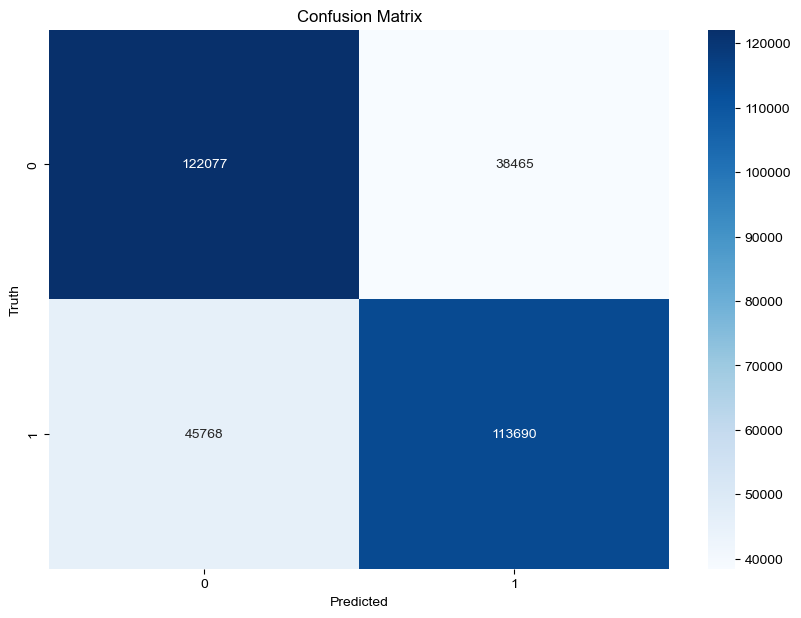

In [22]:
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
y_pred = CNN.predict(X_test)
y_pred_rounded = np.round(y_pred)
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_rounded)
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [23]:
from sklearn.metrics import classification_report


In [24]:
# Print classification report
print(classification_report(y_test, y_pred_rounded, target_names=['Negative', 'Positive']))


              precision    recall  f1-score   support

    Negative       0.73      0.76      0.74    160542
    Positive       0.75      0.71      0.73    159458

    accuracy                           0.74    320000
   macro avg       0.74      0.74      0.74    320000
weighted avg       0.74      0.74      0.74    320000

